<a id='Table of Contents'></a><h3>Table of Contents</h3>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required librairies</a>  
- <a href='#setting_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the `delta_two_lorentz ` model .
</div>

The data are two sets of water data measured at IN5 (ILL) using two different wavelengths.

**Reference:** J. Qvist, H. Schober and B. Halle, J. Chem. Phys. 134, 144508 (2011)

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [32]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
# install bumps (if not already installed)
!{sys.executable} -m pip install bumps

sasview 4.0 requires lxml, which is not installed.
sasview 4.0 requires periodictable>=1.3.1, which is not installed.
sasview 4.0 requires pillow, which is not installed.
sasview 4.0 has requirement pyparsing<2.0.0, but you'll have pyparsing 2.2.0 which is incompatible.
nglview 1.0 has requirement ipywidgets==7, but you'll have ipywidgets 7.0.3 which is incompatible.


 (<a href='#Table of Contents'>Top</a>)<a id='setting_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

These settings are saved in a Python script, which will be used by Bumps to run the fit.

In [3]:
# Name of Python script containing the model
model_file = "model_fit_water1.py"

In [42]:
%%writefile $model_file
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *

path_to_data = './data/'

import h5py
import QENSmodels
import qens_models # to be removed
import numpy as np
from scipy.integrate import simps
from bumps.names import *

# Data
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r')
hw_5A = f['entry1']['data1']['X'][:]
q_5A = f['entry1']['data1']['Y'][:]
sqw_5A = np.transpose(f['entry1']['data1']['DATA'][:])
err_5A = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Wavelength 8 Angstrom
f = h5py.File(path_to_data + 'H2O_293K_8A.hdf', 'r')
hw_8A = f['entry1']['data1']['X'][:]
q_8A = f['entry1']['data1']['Y'][:]
sqw_8A = np.transpose(f['entry1']['data1']['DATA'][:])
err_8A = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Resolution
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'V_273K_5A.hdf', 'r')
res_5A = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Wavelength 8 Angstrom
f = h5py.File(path_to_data + 'V_273K_8A.hdf', 'r')
res_8A = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
# 5 Angstrom
for i in range(len(q_5A)):
    area = simps(res_5A[:,i], hw_5A)
    res_5A[:,i] /= area 
    
# 8 Angstrom
for i in range(len(q_8A)):
    area = simps(res_8A[:,i], hw_8A)
    res_8A[:,i] /= area
    
# Fit range -1 to +1 meV
idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
idx_8A = np.where(np.logical_and(hw_8A > -1.0, hw_8A < 1.0))

def model_convol(x, q, scale=1, center=0, A0=1.0, A1=1.0, hwhm1=1.0, hwhm2=1.0, resolution=None):
    model = QENSmodels.sqwDeltaTwoLorentz(x, q, scale, center, A0, A1, hwhm1, hwhm2)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]

    # Teixeira model    
    #Mq = Curve(qens_models.waterTeixeira, x, data, error,
    Mq = Curve(model_convol, x, data, error, q=q_5A[i],
               scale=20, center=0.0, A0=0.0, A1=0.9, hwhm1=0.05, hwhm2=0.3, 
               resolution=resol)
    # Fitted parameters    
    Mq.scale.range(1.e-12, 20)
    Mq.center.range(-0.1, 0.1)
    Mq.A0.range(0, 0.05)
    Mq.A1.range(0, 1)
    Mq.hwhm1.range(0, 0.5)
    Mq.hwhm2.range(0, 3)
    
    # Q-independent parameters
    if i == 0:
        QA0 = Mq.A0
    else:
        Mq.A0 = QA0
   
    M.append(Mq)
    
# Second dataset: wavelength=8 Angstrom
for i in range(len(q_8A)):

    x = hw_8A[idx_8A]
    data = sqw_8A[idx_8A, i]
    error = err_8A[idx_8A, i]
    resol = res_8A[idx_8A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]
    
    Mq = Curve(model_convol, x, data, error, q=q_8A[i],
               scale=35, center=0.0, A0=0.0, A1=0.9, hwhm1=0.05, hwhm2=0.3, 
               resolution=resol)

    # Fitted parameters    
    Mq.scale.range(0.1, 40)
    Mq.center.range(-0.1, 0.1)
    Mq.A0.range(0, 0.05)
    Mq.A1.range(0, 1)
    Mq.hwhm1.range(0, 0.5)
    Mq.hwhm2.range(0, 3)
    
    # Q-independent parameters
    if i == 0:
        QA0 = Mq.A0
    else:
        Mq.A0 = QA0
          
    M.append(Mq) 
    
problem = FitProblem(M)

Overwriting model_fit_water1.py


<h3> Choice of minimizer for bumps </h3>

In [43]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

Dropdown(description=u'Minimizer:', index=4, options={'Quasi-Newton BFGS': 'newton', 'Random Lines (experimental)': 'rl', 'Parallel Tempering (experimental)': 'pt', 'Particle Swarm (experimental)': 'ps', 'Levenberg-Marquardt': 'lm', 'Differential Evolution': 'de', 'Nelder-Mead Simplex': 'amoeba', 'DREAM': 'dream'}, value='lm')

<h3> Setting for running bumps </h3>

In [44]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

# output folder to save thre results
output_folder = 'QENS'

(<a href='#Table of Contents'>Top</a>)<a id='running_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above
The subfolder *output_folder* contains different results: plots and 
refined parameters

# /Users/celinedurniak/anaconda/envs/aseenv/lib/python2.7/site-packages/bumps/cli.py model_fit_water1.py --fit=lm --steps=100 --store=QENS
-- Model 0 
.A0 = Parameter(0, name='A0', bounds=(0,0.05))
.A1 = Parameter(0.9, name='A1', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.hwhm1 = Parameter(0.05, name='hwhm1', bounds=(0,0.5))
.hwhm2 = Parameter(0.3, name='hwhm2', bounds=(0,3))
.q = Parameter(0.5, name='q')
.scale = Parameter(20, name='scale', bounds=(1e-12,20))

[chisq=30178.308(98), nllf=1.08642e+06]
-- Model 1 
.A0 = Parameter(0, name='A0', bounds=(0,0.05))
.A1 = Parameter(0.9, name='A1', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.hwhm1 = Parameter(0.05, name='hwhm1', bounds=(0,0.5))
.hwhm2 = Parameter(0.3, name='hwhm2', bounds=(0,3))
.q = Parameter(0.6, name='q')
.scale = Parameter(20, name='scale', bounds=(1e-12,20))

[chisq=78.467(89), nllf=3099.46]
-- Model 2 
.A0 = Parameter(0, name='A0', bounds=(0,0.05))
.A1 = Parameter(0

-- Model 0 
.A0 = Parameter(0, name='A0', bounds=(0,0.05))
.A1 = Parameter(0.9, name='A1', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.hwhm1 = Parameter(0.05, name='hwhm1', bounds=(0,0.5))
.hwhm2 = Parameter(0.3, name='hwhm2', bounds=(0,3))
.q = Parameter(0.5, name='q')
.scale = Parameter(20, name='scale', bounds=(1e-12,20))

[chisq=30178.308(98), nllf=1.08642e+06]
-- Model 1 
.A0 = Parameter(0, name='A0', bounds=(0,0.05))
.A1 = Parameter(0.9, name='A1', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.hwhm1 = Parameter(0.05, name='hwhm1', bounds=(0,0.5))
.hwhm2 = Parameter(0.3, name='hwhm2', bounds=(0,3))
.q = Parameter(0.6, name='q')
.scale = Parameter(20, name='scale', bounds=(1e-12,20))

[chisq=78.467(89), nllf=3099.46]
-- Model 2 
.A0 = Parameter(0, name='A0', bounds=(0,0.05))
.A1 = Parameter(0.9, name='A1', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.hwhm1 = Parameter(0.05, name='hwhm1', bounds=(0,0.5)

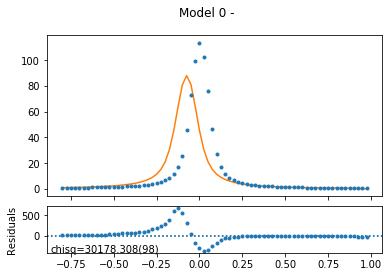

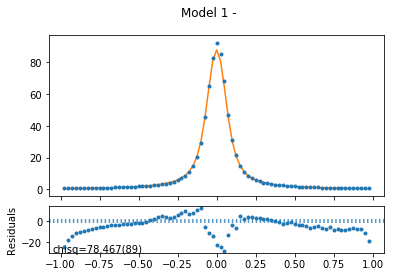

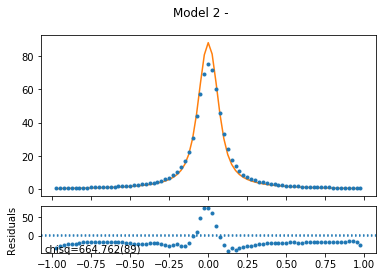

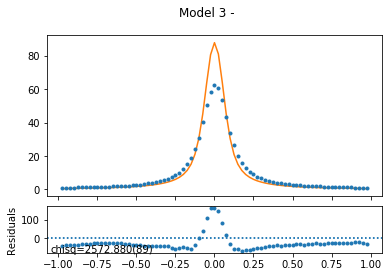

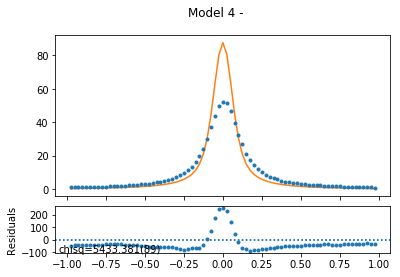

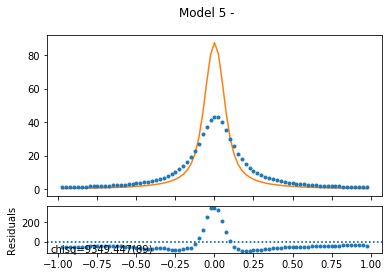

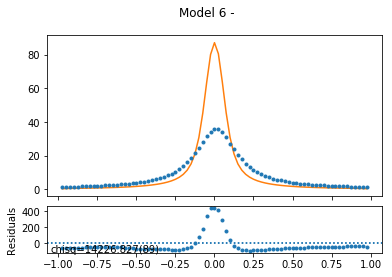

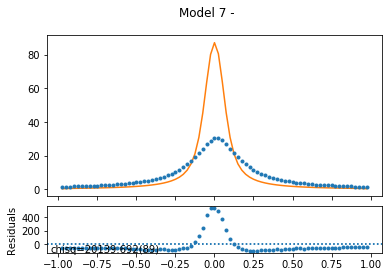

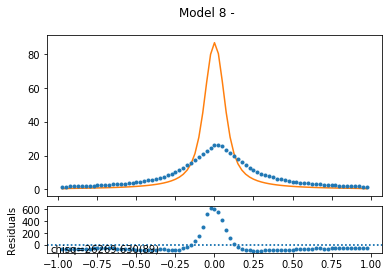

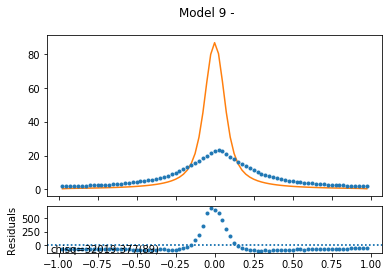

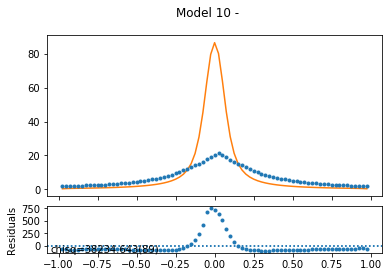

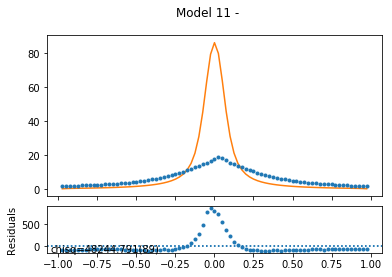

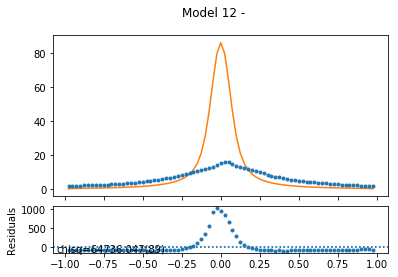

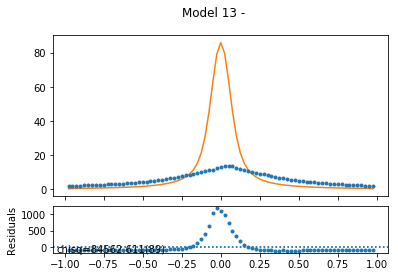

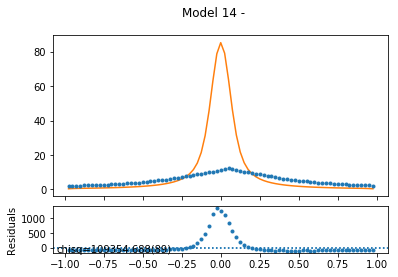

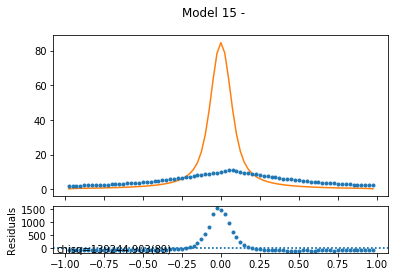

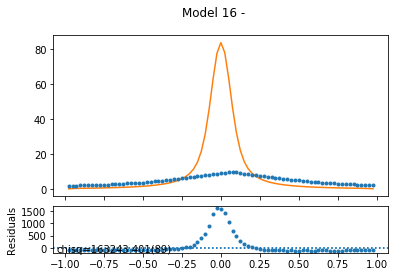

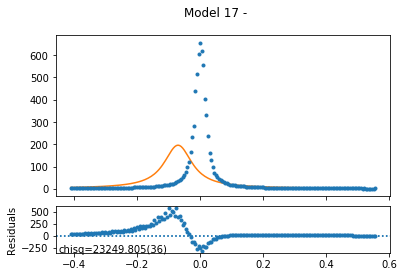

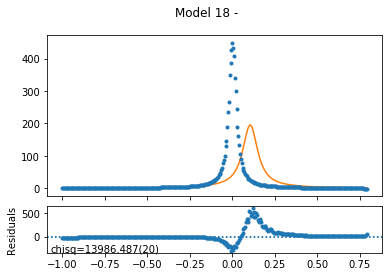

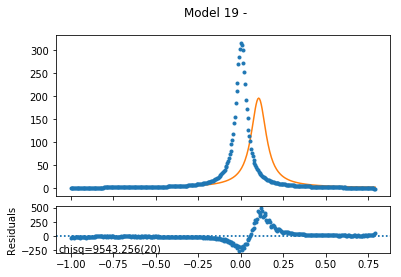

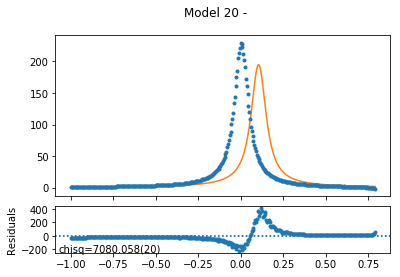

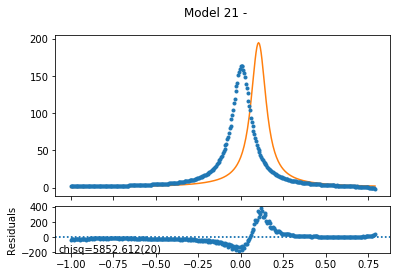

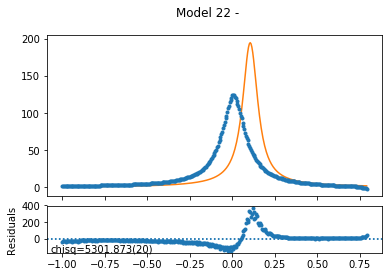

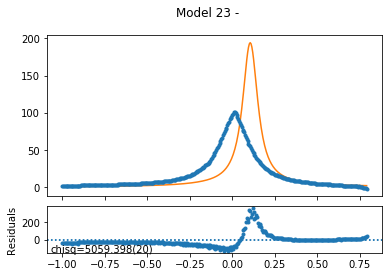

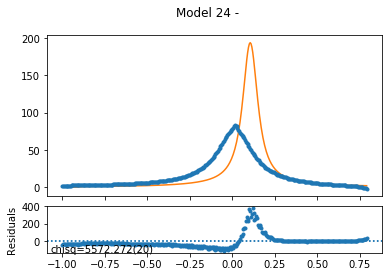

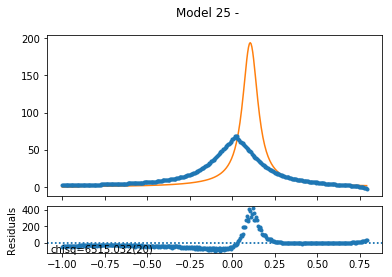

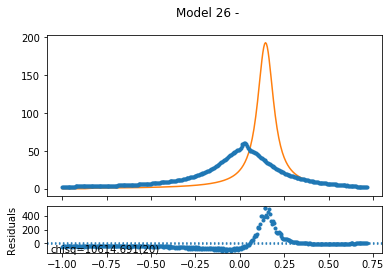

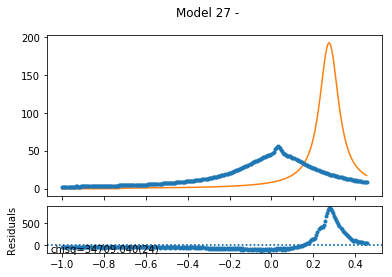

In [45]:
%run -m bumps.cli $model_file --fit=$minimiser --steps=$steps --store=$output_folder

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

In [46]:
# DISPLAY SOME RESULTS (Bumps output)
par_file = os.path.splitext(model_file)[0] + '.par'
err_file = os.path.splitext(model_file)[0] + '.err'

with open(os.path.join('.', output_folder, par_file), 'r') as fid:
    for line in fid:
        parameter, value = line.split()
        print(parameter, value)
        
with open(os.path.join(os.getcwd(), output_folder, err_file), 'r') as ferr:
    for line in ferr:
        print(line.rsplit('\n')[0])

A0 0
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 20
A0 0
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 35
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 35
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 35
A1 0.9
center 0
hwhm1 0.05
hwhm2 0.3
scale 35
A1 0.9
center 0
hwhm1 0.

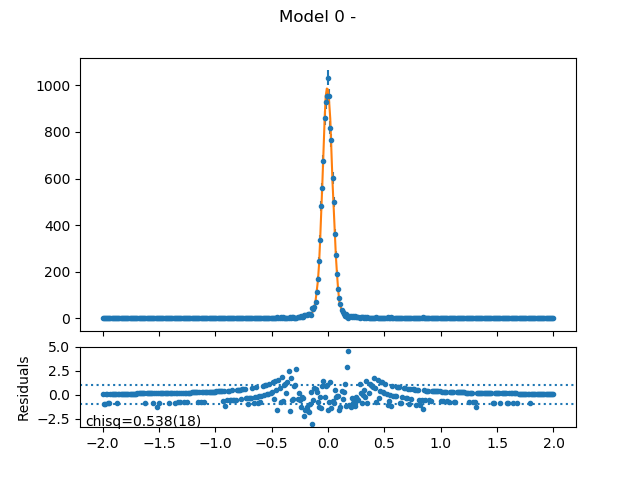

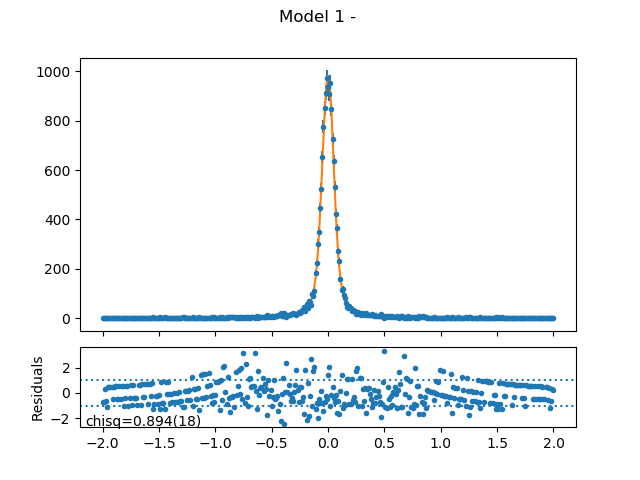

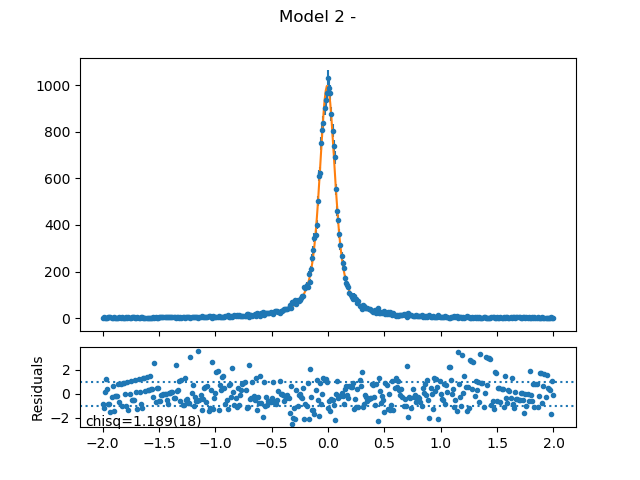

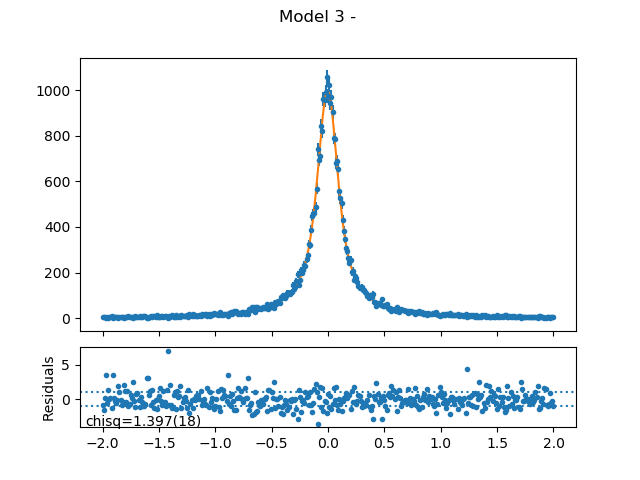

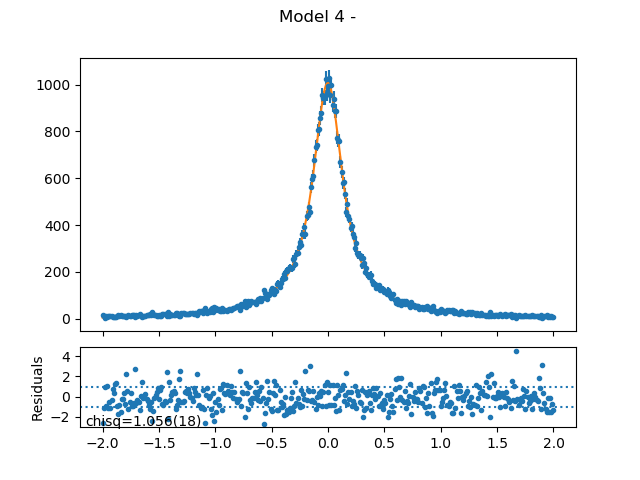

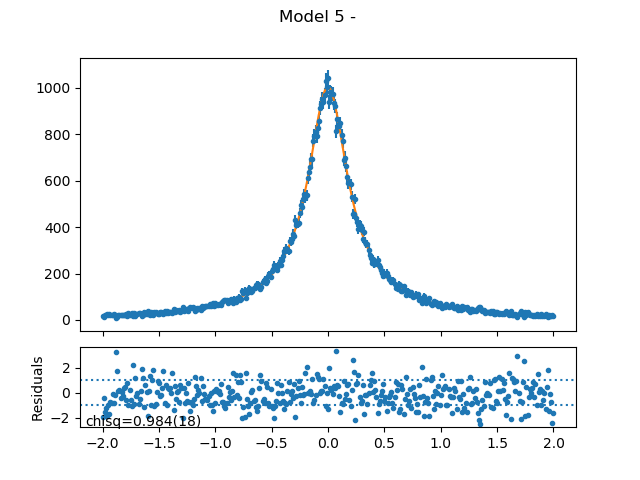

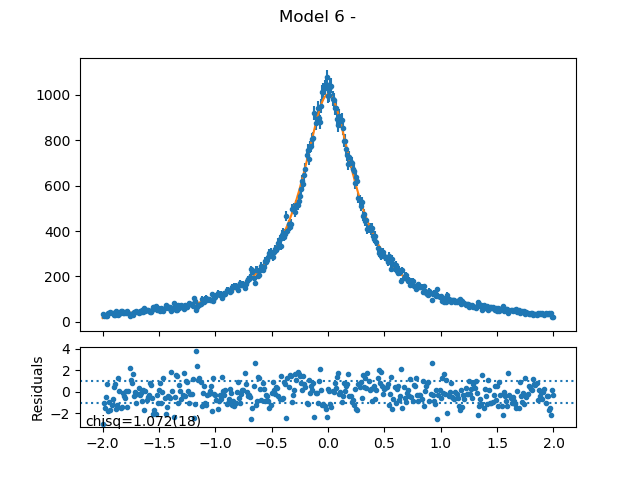

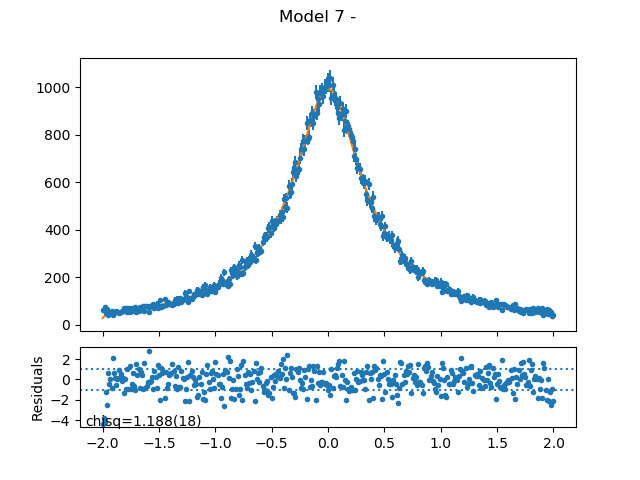

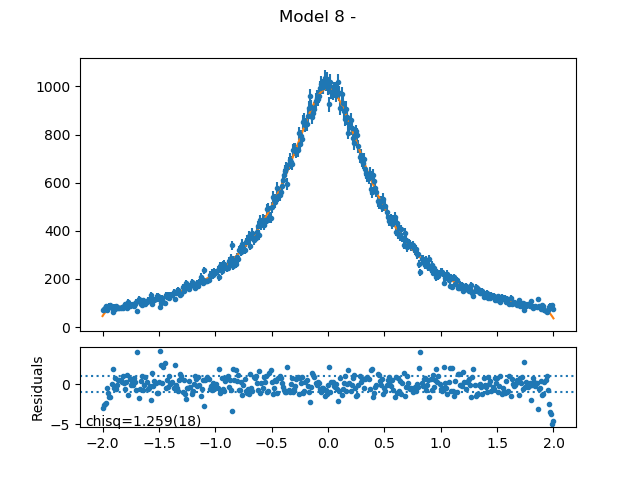

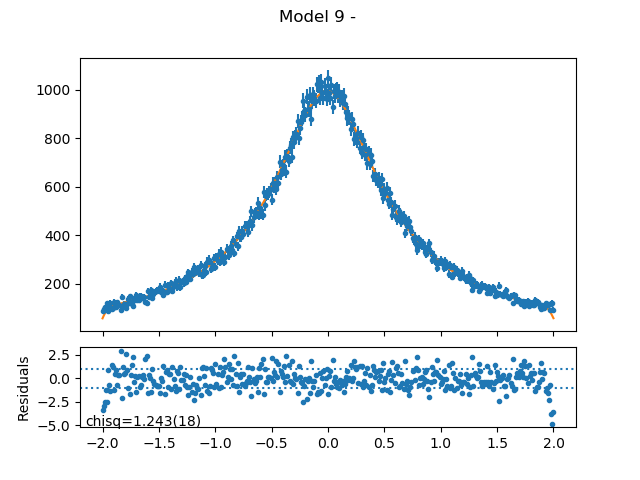

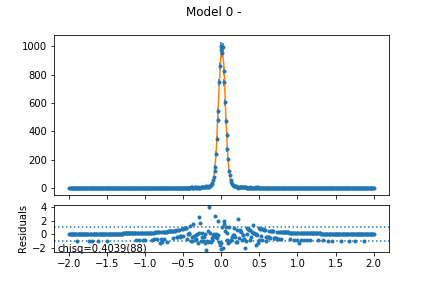

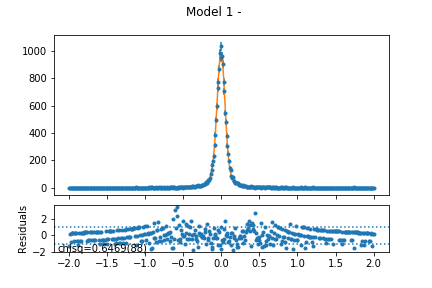

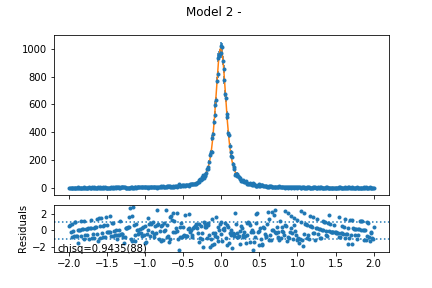

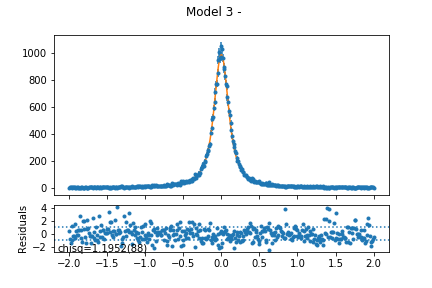

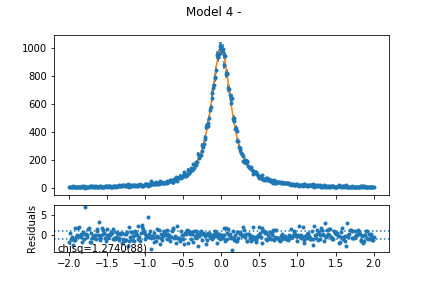

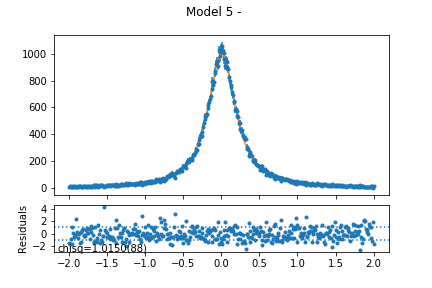

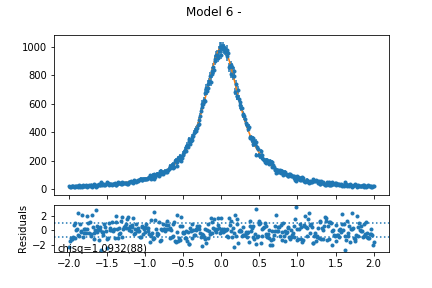

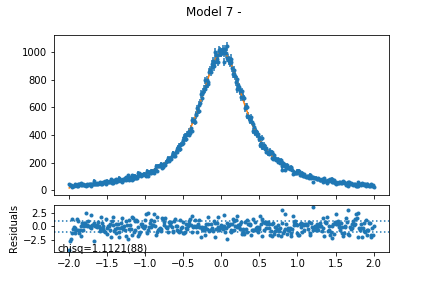

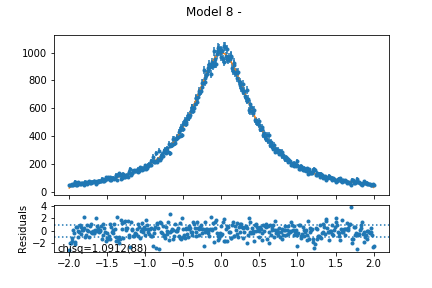

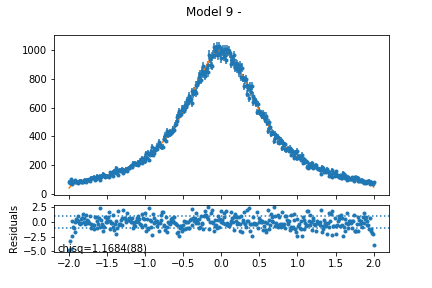

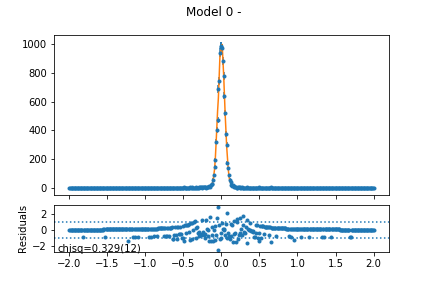

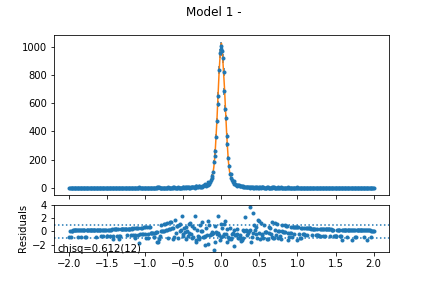

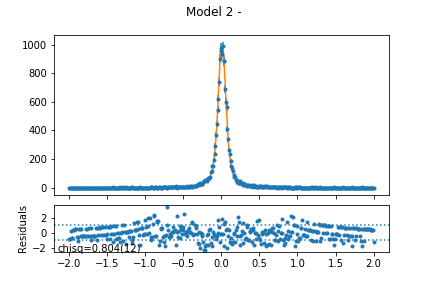

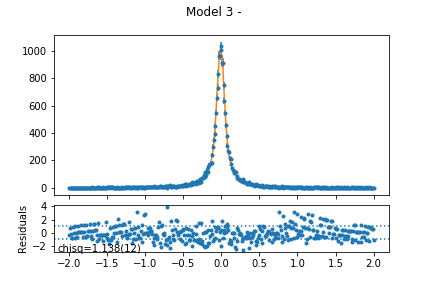

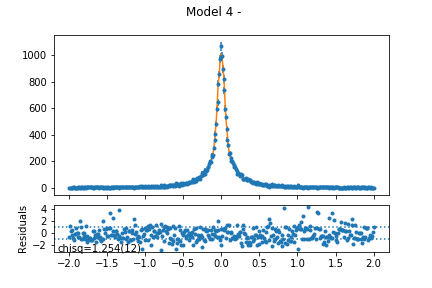

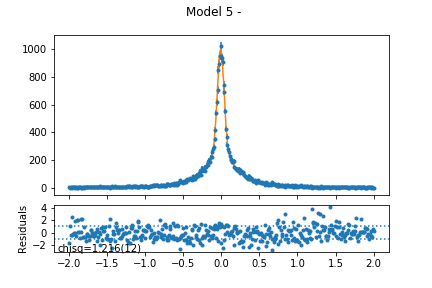

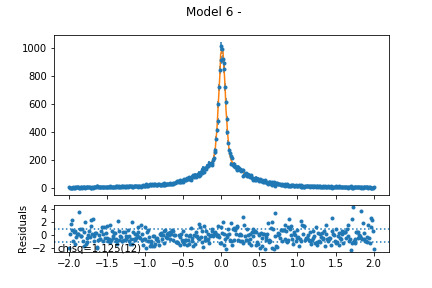

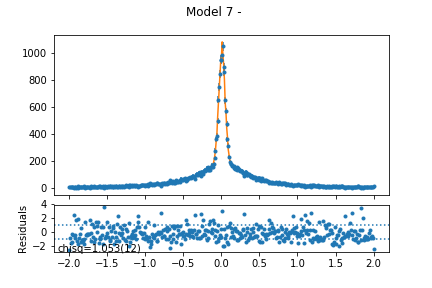

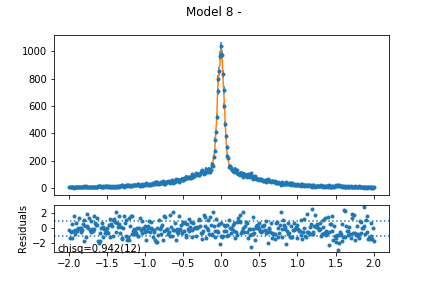

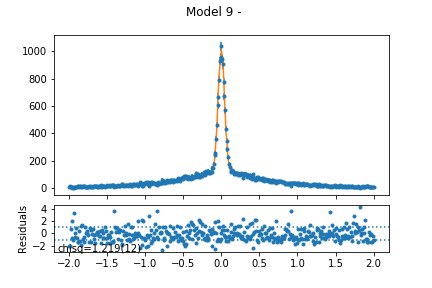

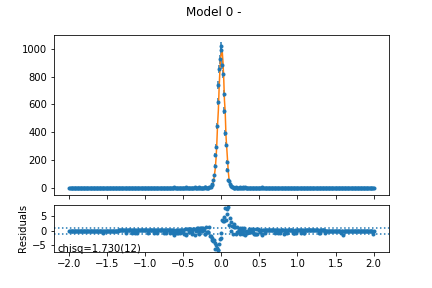

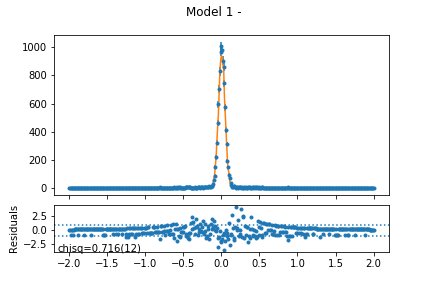

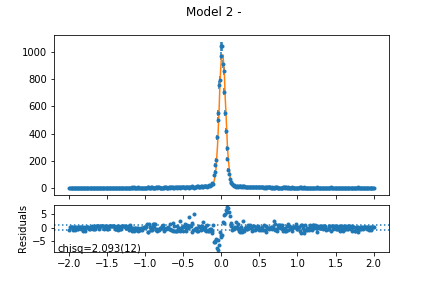

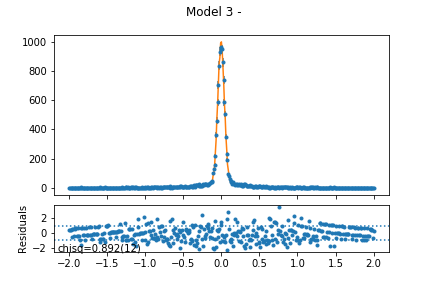

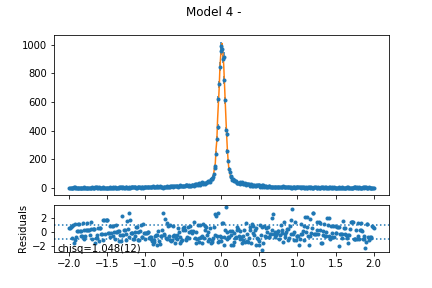

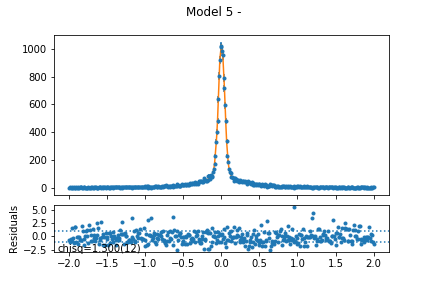

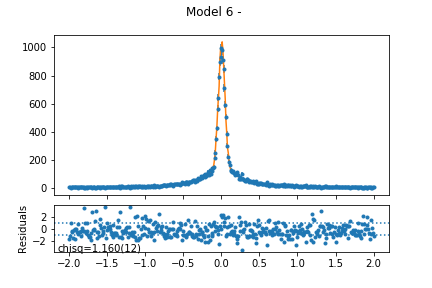

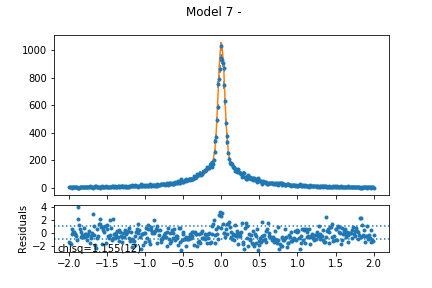

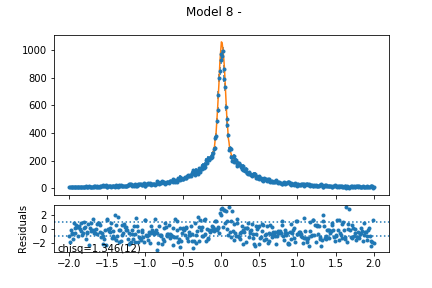

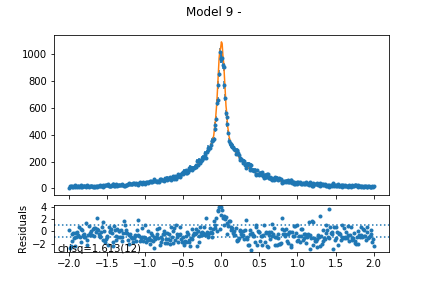

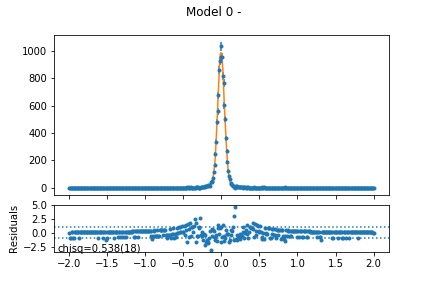

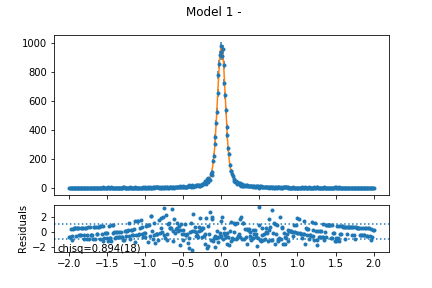

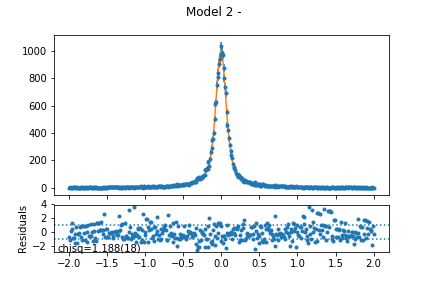

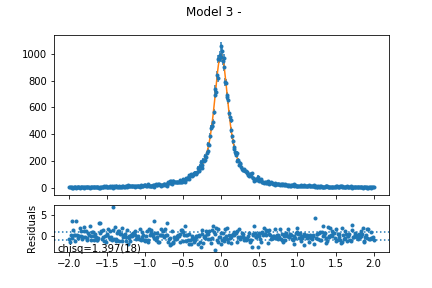

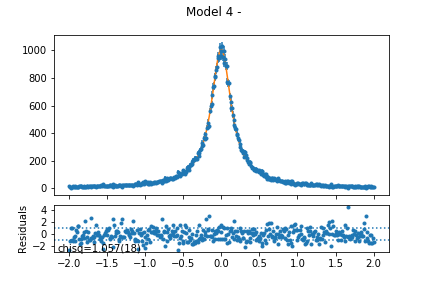

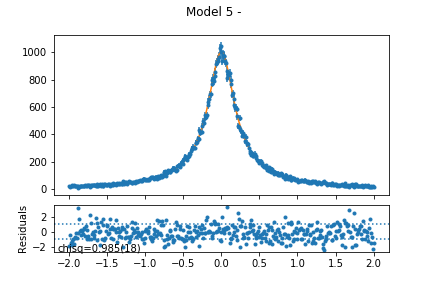

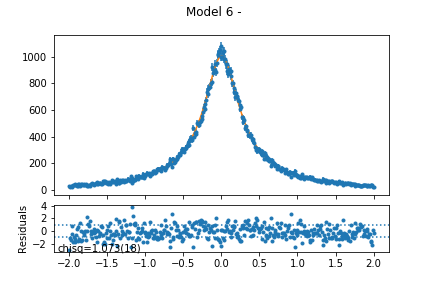

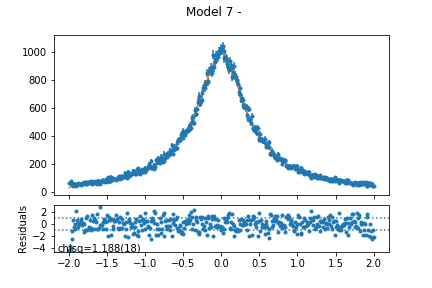

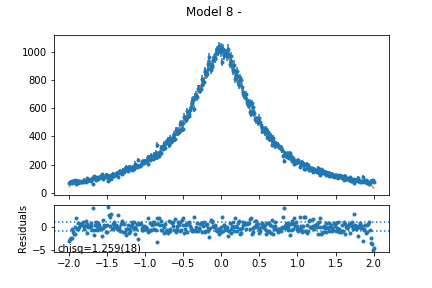

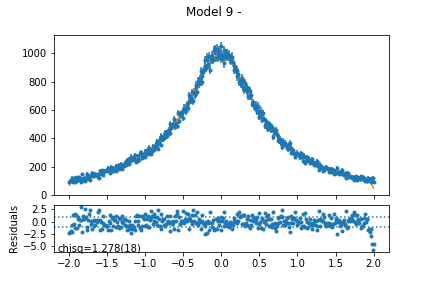

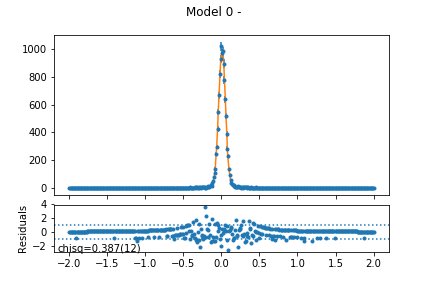

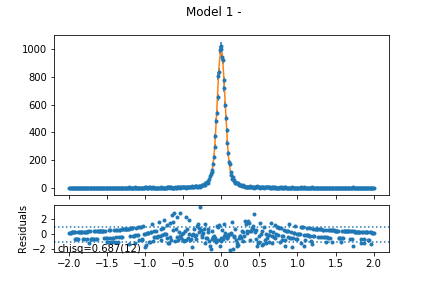

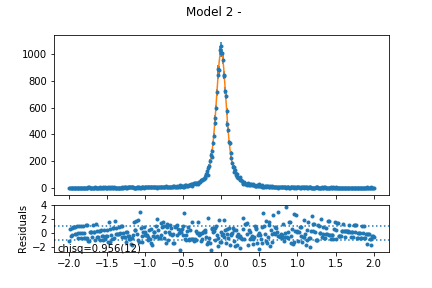

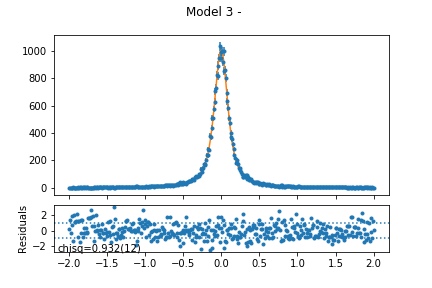

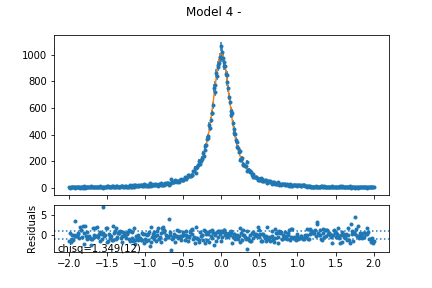

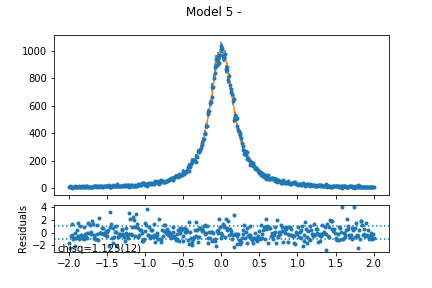

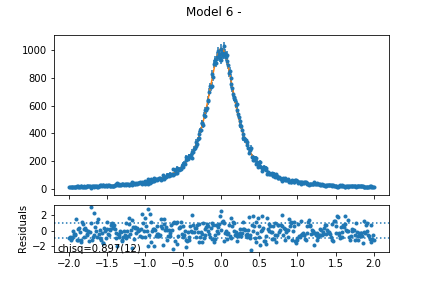

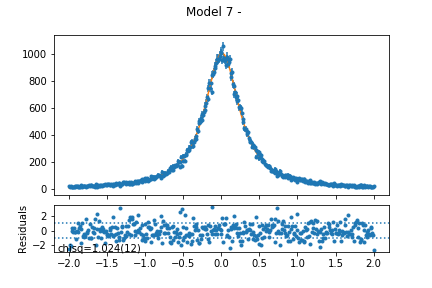

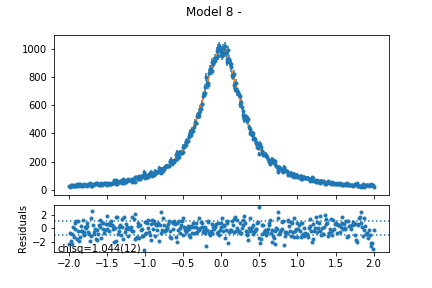

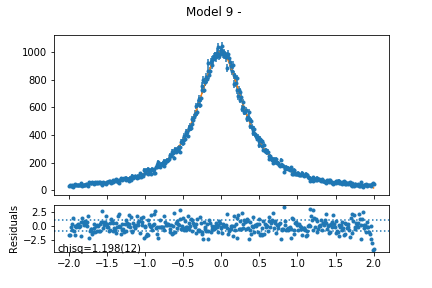

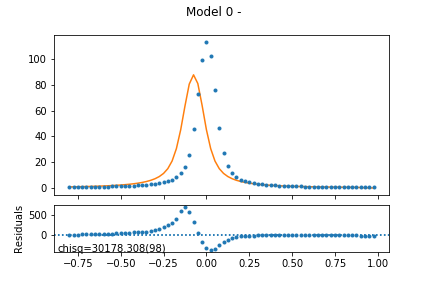

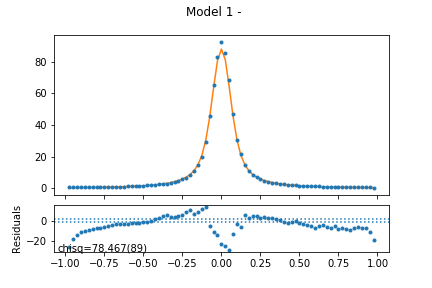

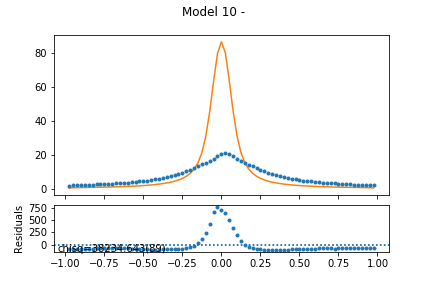

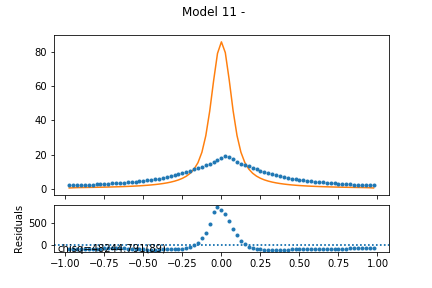

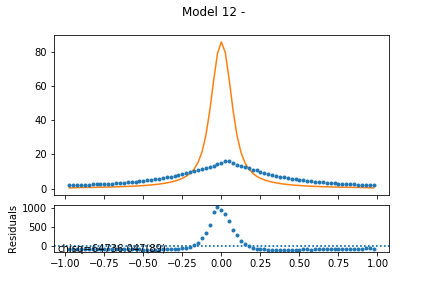

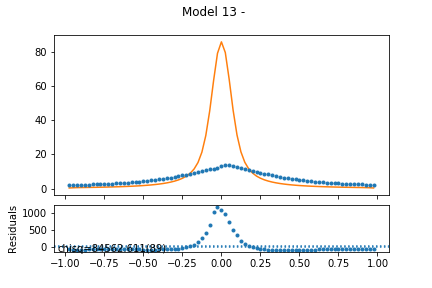

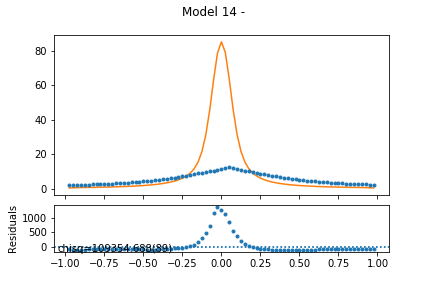

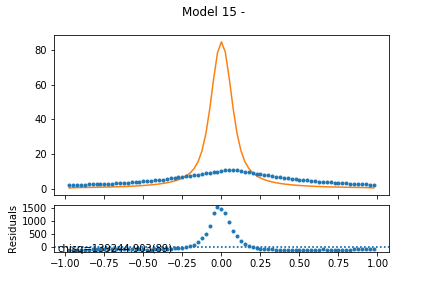

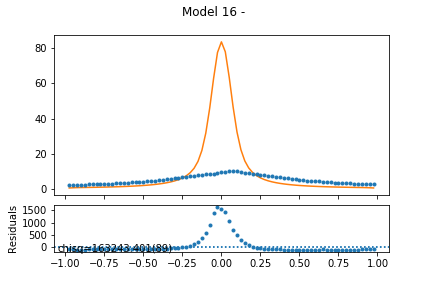

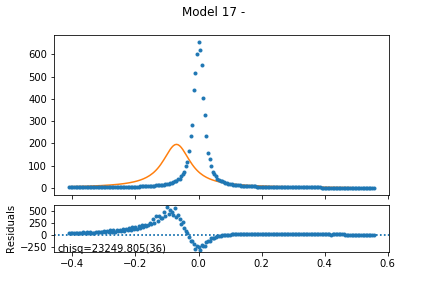

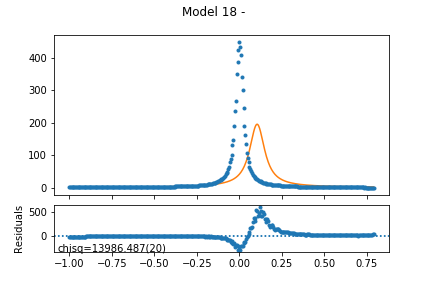

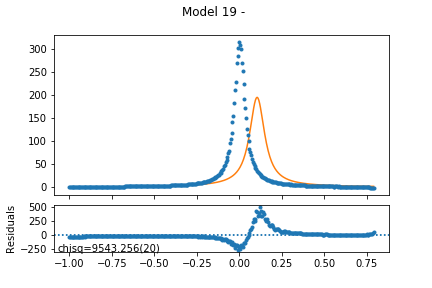

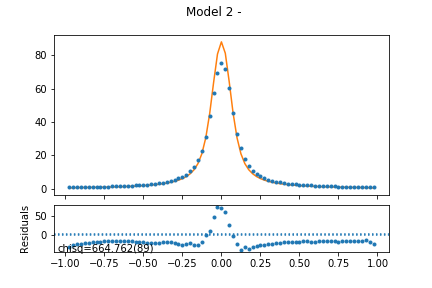

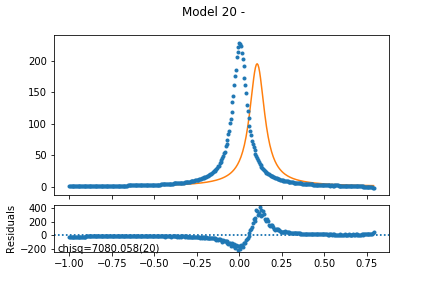

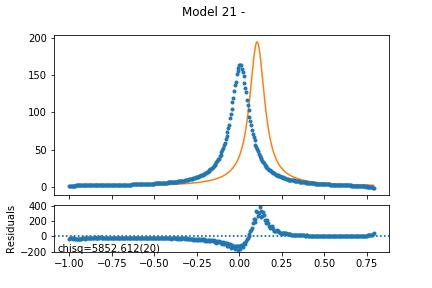

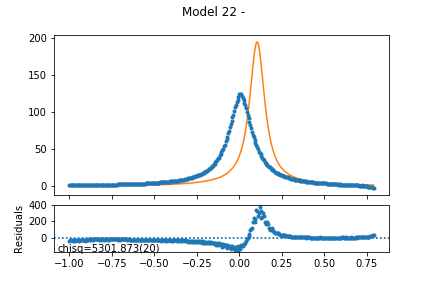

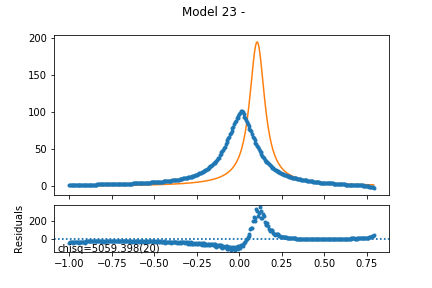

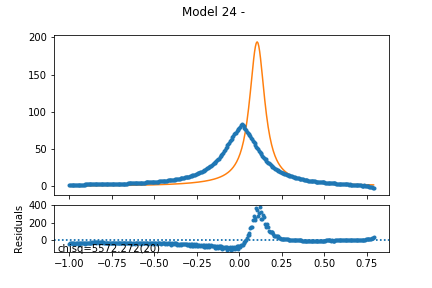

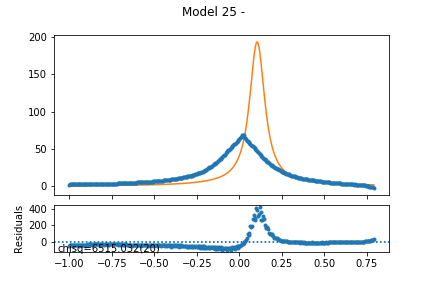

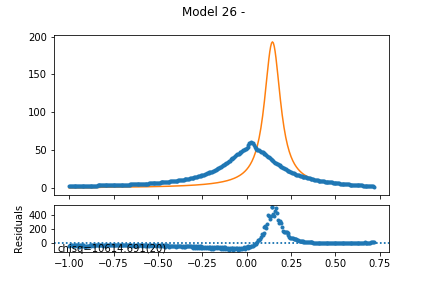

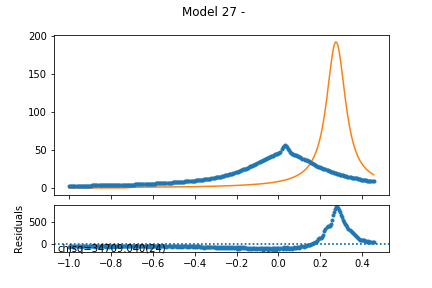

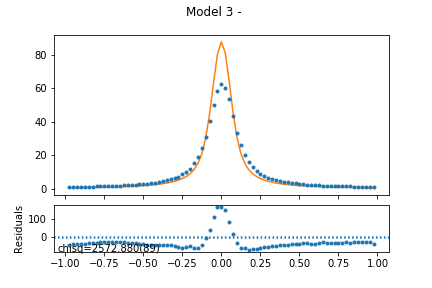

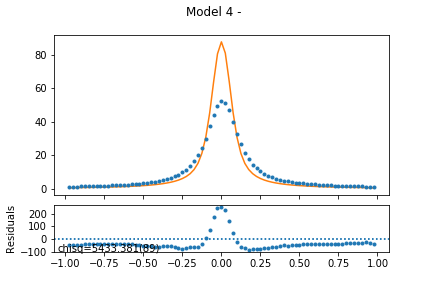

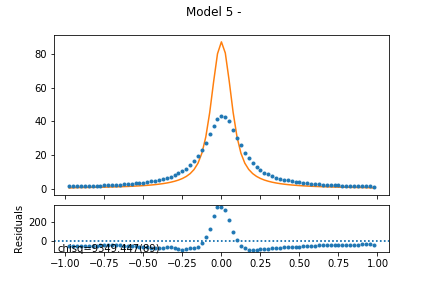

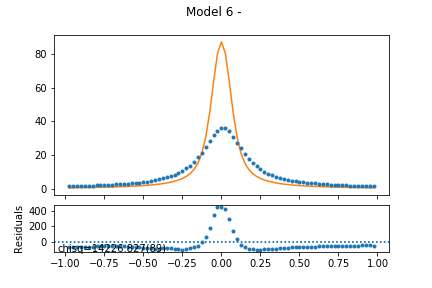

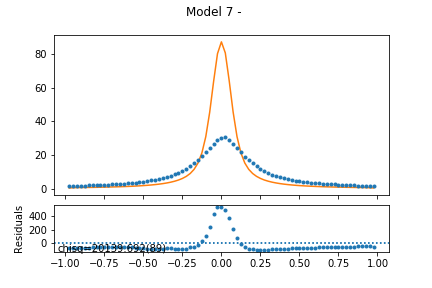

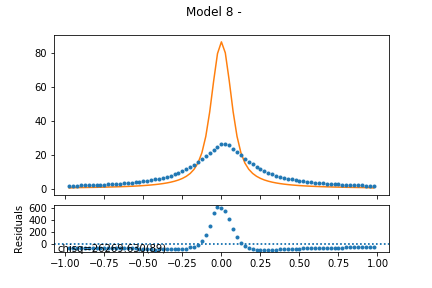

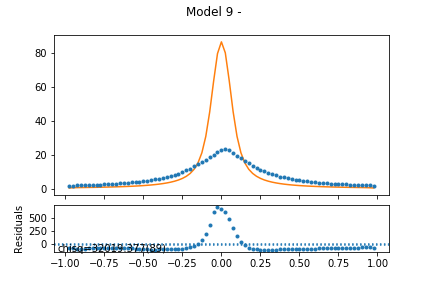

In [47]:
# Plot the fitting results

from IPython.display import display, Image
relative_output_path = os.path.join('.', output_folder)
names = [f for f in os.listdir(relative_output_path) if f.endswith('.png')]

for name in names:
    display(Image(os.path.join(relative_output_path, name)))